A C -> B

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

In [2]:
# Circuito para medir V

def param(h,k):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2)


# Define the parameters

def qc_V(h,k):

    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.x(qr[0])
    qc.ry(2*theta,qr[0])
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    qc.x(qr[0])
    qc.ry(2*theta,qr[1])
    qc.cx(qr[0],qr[1])
    qc.barrier()

    # Alice's projective measurement
    qc.h(qr[0])
    qc.barrier()

    #Bob's conditional operation on A
    phi = 0.5*np.arcsin(param(h,k))
    qc.cry(-2*phi,qr[0],qr[2])

    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[2])
    qc.x(qr[0])

    #Bob's conditional operation on A
    qc.cry(-2*phi,qr[1],qr[2])
    qc.x(qr[1])
    qc.cry(2*phi,qr[1],qr[2])
    qc.x(qr[1])


    #Measurement of the interaction V
    qc.h(qr[1])
    qc.measure_all()

    return qc

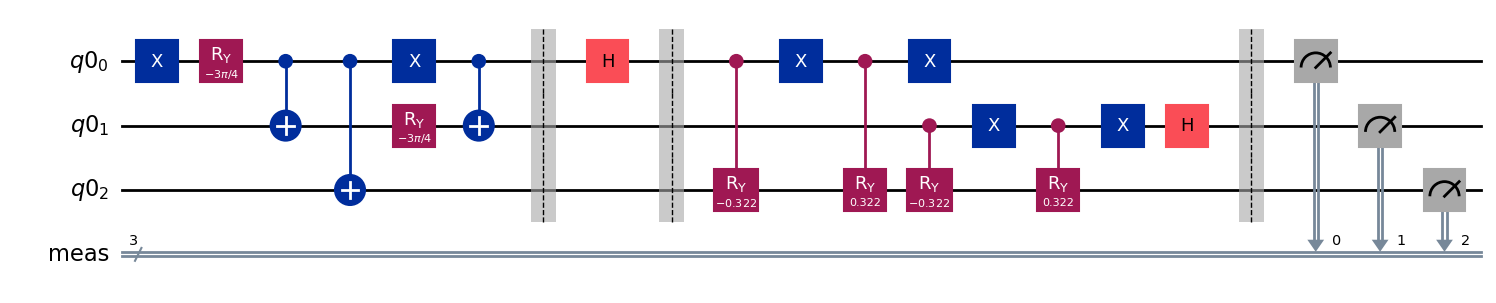

In [3]:
qc = qc_V(1, 1)
qc.draw('mpl')

In [4]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1.5; k = 1;
n_shots = 100000

# Generate circuit
qc = qc_V(h, k)
qc_A = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = sampler().run([qc_A], shots=n_shots)

Exact E_A =  1.2480754415067656
Alice's local energy =  1.2408754415067655 ± 0.004743361845779846
Interacting energy, V =  0.9067603924504583 ± 0.005702494365100239


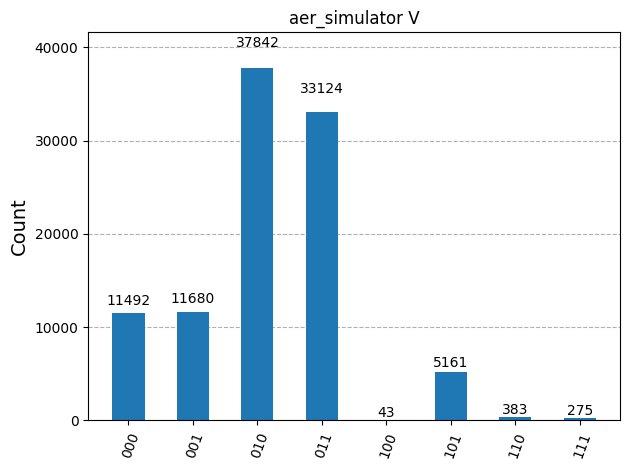

In [5]:
result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()


ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

error_A = []
error_V = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Exact E_A = ",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy = ",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy, V = ",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator V')